In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [4]:
actor = branch_actor((2,),(2,))

In [5]:
# init
actor.load_weights('../saved_agent/linear_init_extend_actor.h5')

In [6]:
memory_limit = 20000
memory = []
alpha = 0.07
beta = 1.
low = np.array([-10., 0.01])
high = np.array([10, 10.])
for i in range(memory_limit):
    env.reset()
    reward = 0
    state0 = env.state
    a_agent, tau = np.random.uniform(low=low, high=high)
    tau = np.clip(tau, 0.01, 1.)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        r *= np.exp(- 0.4 * alpha * p) # 各時刻のリワードは割引されるべき
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    memory.append([state0, np.array([a_agent, tau]), reward, state1])
    print('\r' + f'{int(i*100/memory_limit)} %', end='')
memory = np.array(memory)

99 %

In [7]:
print(memory.shape)

(20000, 4)


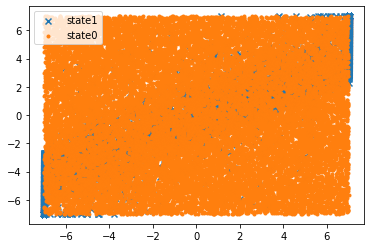

In [8]:
action_memory = np.array(memory[:,1].tolist())
state0_memory = np.array(memory[:,0].tolist())
state1_memory = np.array(memory[:,3].tolist())
plt.scatter(state1_memory[:,0], state1_memory[:,1], marker='x', label='state1')
plt.scatter(state0_memory[:,0], state0_memory[:,1], marker='.', label='state0')
plt.legend()
plt.show()